In [1]:
import sys
sys.path.append('C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\kerasapplications')
sys.path.append('C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\efficientnet-keras-source-code\\')
import keras_applications
import efficientnet.tfkeras as efficientnet

C:\Users\public.DESKTOP-P7554KD\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
import cv2
import glob
import traceback
import cv2 as cv
import numpy as np
import pandas as pd
from path import Path
from tqdm import tqdm
import nibabel as nib
import pydicom as dicom
import tensorflow as tf
from keras import layers
from pydicom import dcmread
from tensorflow import keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from pydicom.data import get_testdata_files
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import dask.array as da
from PIL import Image as im
import imageio


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cv2
import os
from os import listdir
import re
import gc

import gdcm
import pydicom
from pydicom import dcmread
import pylibjpeg
from pydicom.pixel_data_handlers.util import apply_voi_lut
from pydicom.data import get_testdata_files

from path import Path
import scipy.ndimage
from tqdm import tqdm
import nibabel as nib
from pprint import pprint
from time import time
import itertools
from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from glob import glob
import warnings
import dask.array as da

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
from keras.preprocessing.image import ImageDataGenerator
from keras import layers

from path import Path
from PIL import Image as im

import imageio


#from efficientnet_v2 import EfficientNetV2S
%matplotlib inline
sns.set(style='darkgrid', font_scale=1.6)

### Data Loading

> **Note:** Mean target calculation for a baseline submission.

In [4]:
bad = np.array([['1.2.826.0.1.3680043.10197_C1', '1.2.826.0.1.3680043.10197','C1'],['1.2.826.0.1.3680043.10454_C1', '1.2.826.0.1.3680043.10454','C1'],['1.2.826.0.1.3680043.10690_C1', '1.2.826.0.1.3680043.10690','C1']], dtype=np.object)

train_df = pd.read_csv("C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\train.csv")
test_df = pd.read_csv("C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\test.csv")

train_dir = 'C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\train_images'
test_dir = 'C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\test_images'
first_image = os.path.join(test_dir, test_df['StudyInstanceUID'].iloc[0])

new_submission = []
means = train_df.median(numeric_only=True).to_dict()
means = dict(zip(train_df.columns[1:], 
                 np.average(train_df[train_df.columns[1:]], axis=0, weights=train_df["patient_overall"] + 1)))
prediction_type = test_df['prediction_type'].tolist()
submission = pd.read_csv('C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\sample_submission.csv')

for i in range(len(submission)):        
    new_submission.append(means[prediction_type[i]])
submission['fractured'] = new_submission


if(test_df.values[0][0] == bad[0][0]): test_df = pd.DataFrame({"row_id": ['1.2.826.0.1.3680043.22327_C1', '1.2.826.0.1.3680043.25399_C1', '1.2.826.0.1.3680043.5876_C1'], "StudyInstanceUID": ['1.2.826.0.1.3680043.22327', '1.2.826.0.1.3680043.25399', '1.2.826.0.1.3680043.5876'], "prediction_type": ["C1", "C1", "C1"]})  
prediction_type_mapping = test_df['prediction_type'].map({'C1': 0, 'C2': 1, 'C3': 2, 'C4': 3, 'C5': 4, 'C6': 5, 'C7': 6}).values

C:\Users\public.DESKTOP-P7554KD\AppData\Local\Temp\ipykernel_15384\1113605710.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bad = np.array([['1.2.826.0.1.3680043.10197_C1', '1.2.826.0.1.3680043.10197','C1'],['1.2.826.0.1.3680043.10454_C1', '1.2.826.0.1.3680043.10454','C1'],['1.2.826.0.1.3680043.10690_C1', '1.2.826.0.1.3680043.10690','C1']], dtype=np.object)


#### Utility Functions & Variables

- **load_dicom:** For loading (and converting) a single dicom image.
- **lisdirs:** For listing the data directory.
- **train_dir / test_dir:** used later on for fast switching between train & validation paths

In [5]:
#Loading Scans
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]

# Load the scans in given folder path
def load_scan(path):
    
    dcm_paths = glob(f"{path}/*")
    dcm_paths.sort(key=natural_keys)
    
    patient_scan = [dicom.dcmread(paths) for paths in dcm_paths]
    
    return patient_scan

In [6]:
def get_pixels_hu(slices):
   
    image = np.stack([cv2.resize(s.pixel_array,(256,256),interpolation = cv2.INTER_NEAREST) for s in slices])
    #image = np.stack([cv2.cvtColor(s.pixel_array.reshape(512,512),cv2.COLOR_GRAY2RGB) for s in slices])

    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16) #int16
    image = da.from_array(image) #Using Dask to speed up processing
    
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image <= -1000] = 0
    
    # Convert to Hounsfield units (HU)
        
    intercept = da.from_array([slices[slice_number].RescaleIntercept for slice_number in range(len(slices))])
    slope = da.from_array([slices[slice_number].RescaleSlope for slice_number in range(len(slices))])
    
    intercept=intercept.reshape((-1,1,1))
    slope=slope.reshape((-1,1,1))
    #print(slope.shape)
    #print(image.shape)
    image= slope * image.astype("float64")
    #print(image.shape)   
    image+= intercept
    #print(image.shape)      
    return image.astype("int16")

In [7]:
MIN_BOUND = 150.0
MAX_BOUND = 2050.0
    
def normalize(image):
    image = (image - MIN_BOUND)*255.0 / (MAX_BOUND - MIN_BOUND)
    image[image>255] = 255.
    image[image<0] = 255.
    
    image = image.astype(np.int16)
    return image

In [9]:
#Example Scan
path_scan=f"C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\train_images\\1.2.826.0.1.3680043.10633"
image=load_scan(path_scan)

(-0.5, 511.5, 511.5, -0.5)

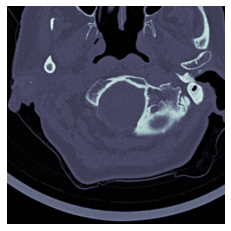

In [10]:
#Ploting pixel array
plt.imshow(image[110].pixel_array,cmap='bone')
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

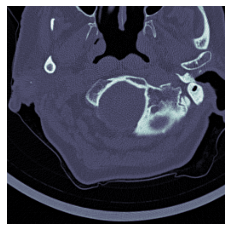

In [11]:
patient_slice=get_pixels_hu(image)

#Ploting HU array
plt.imshow(patient_slice[110],cmap='bone')
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

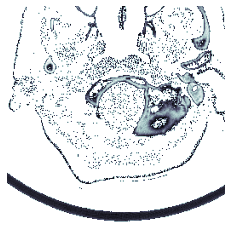

In [12]:
image=normalize(patient_slice)

plt.imshow(image[110],cmap="bone")
plt.axis("off")

In [13]:
model_classification = keras.models.load_model('C:\\Users\\public.DESKTOP-P7554KD\\Downloads\\Classifier_v3.h5')

In [8]:
def pred_label(threshold=0.46):
    val_pred_cleaned = []
    for i in val_pred:
        image_clean = []
        for j in i:
            if j >threshold:
                image_clean.append(1.0)
            else:
                image_clean.append(0.0)
        image_clean = np.array(image_clean)

        val_pred_cleaned.append(image_clean)
        
    return val_pred_cleaned

In [15]:
infer_ds_x_updated_np=np.reshape(infer_ds_x_updated_np,(-1,512,512,1))
infer_pred = model.predict(infer_ds_x_updated_np,
                         use_multiprocessing=True) 

NameError: name 'infer_ds_x_updated_np' is not defined

### Testing with 1 patient

In [17]:
trainset = []
trainidt = []
trainlabel = []
        

idt = '1.2.826.0.1.3680043.10633'
            
            #need a step to skip ids that are outlier
            
path = os.path.join(train_dir, idt)
print(path)
patient_scan=load_scan(path)
patient_hu=get_pixels_hu(patient_scan)
patient_hu_normalised=normalize(patient_hu)
        
for i in range(len(os.listdir(path))):
    img = patient_hu_normalised[i]
    img = np.array(img)
    
    #infer_img=np.reshape(img,(-1,512,512,1))
    #infer_pred = model_classification.predict(infer_img,use_multiprocessing=True) 
    
    img = cv.resize(img, (128 , 128))
    image = img_to_array(img)
    image = image / 255.0
    
    trainset += [image]
    cur_label = []
    cur_label.append(train_df.loc[1049,'C1'])
    cur_label.append(train_df.loc[1049,'C2'])
    cur_label.append(train_df.loc[1049,'C3'])
    cur_label.append(train_df.loc[1049,'C4'])
    cur_label.append(train_df.loc[1049,'C5'])
    cur_label.append(train_df.loc[1049,'C6'])
    cur_label.append(train_df.loc[1049,'C7'])
    trainlabel += [cur_label]
    trainidt += [idt]
    


C:\Users\public.DESKTOP-P7554KD\Downloads\train_images\1.2.826.0.1.3680043.10633


In [18]:
patient_hu_normalised[110]

dask.array<getitem, shape=(256, 256), dtype=int16, chunksize=(256, 256), chunktype=numpy.ndarray>

(-0.5, 255.5, 255.5, -0.5)

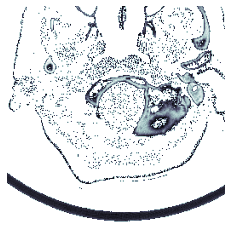

In [19]:

plt.imshow(patient_hu_normalised[110],cmap="bone")
plt.axis("off")

#### Train Generator 

- Also yields labels

In [9]:
def RSNATrainGenerator(train_df, batch_size, infinite = True, base_path = train_dir):
    while True:
        trainset = []
        trainidt = []
        trainlabel = []
        for i in (range(len(train_df))):
            idt = train_df.loc[i, 'StudyInstanceUID']
            
            #need a step to skip ids that are outlier
            
            path = os.path.join(train_dir, idt)
            
            patient_scan=load_scan(path)
            patient_hu=get_pixels_hu(patient_scan)
            patient_hu_normalised=normalize(patient_hu)
            
            for j in range(len(os.listdir(path))):
                img = patient_hu_normalised[j]
                img = np.array(img)
                img = cv.resize(img, (256 , 256))
                image = img_to_array(img)
                image = image / 255.0
                trainset += [image]
                cur_label = []
                cur_label.append(train_df.loc[i,'C1'])
                cur_label.append(train_df.loc[i,'C2'])
                cur_label.append(train_df.loc[i,'C3'])
                cur_label.append(train_df.loc[i,'C4'])
                cur_label.append(train_df.loc[i,'C5'])
                cur_label.append(train_df.loc[i,'C6'])
                cur_label.append(train_df.loc[i,'C7'])
                trainlabel += [cur_label]
                trainidt += [idt]
                if len(trainidt) == batch_size:                    
                    yield np.array(trainset), np.array(trainlabel)
                    trainset, trainlabel, trainidt = [], [], []
            i+=1

#### Test Generator

- Yields only image samples

In [10]:
def RSNATestGenerator(test_df, batch_size, infinite = True, base_path = test_dir):
    while 1:        
        testset=[]
        testidt=[]
        for i in (range(len(test_df))):        
            if type(test_df) is list: idt = test_df[i]
            else: idt = test_df['StudyInstanceUID'].iloc[i]
            path = os.path.join(base_path, idt)
            
            patient_scan=load_scan(path)
            patient_hu=get_pixels_hu(patient_scan)
            patient_hu_normalised=normalize(patient_hu)
            
            if os.path.exists(path):
                 for j in range(len(os.listdir(path))):
                    img = patient_hu_normalised[j]
                    img = np.array(img)
                    img=cv.resize(img,(256, 256))
                    image=img_to_array(img)
                    image=image/255.0
                    testset+=[image]
                    testidt+=[idt]
                    if len(testset) == batch_size:                        
                        yield np.array(testset)
                        testset = []
        if len(testset) > 0: yield np.array(testset)
        if not infinite: break

#### The Model

> **Note:** The training data loads as a single channel image, we use a simple `Conv2D` to align it to be a 3 channel image (As expected by efficientnet).

In [11]:
def get_model():
    inp = keras.layers.Input((None, None ,1))
    x = Conv2D(3, 3, padding = 'SAME')(inp)
    x = efficientnet.EfficientNetB5(include_top=False, weights='imagenet')(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    out = keras.layers.Dense(7, 'sigmoid')(x)
    model = keras.models.Model(inp, out)
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001))
    return model

#### Main Training Cell

We use a stratified (based on patient_overall) KFold split and train 5 different models. 

In [12]:
for train_idx, val_idx in StratifiedKFold(5).split(train_df, train_df['patient_overall']):
    i=1
    K.clear_session()
    x_train = train_df.iloc[train_idx].reset_index()
    x_val = train_df.iloc[val_idx].reset_index()
    model = get_model()
    hist = model.fit_generator(                            
                                    RSNATrainGenerator(x_train, min(len(x_train), 128), 
                                                       infinite = False, 
                                                       base_path = train_dir),
                                    epochs = 10,
                                    verbose = 1,
                                    callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                                               patience = 2, 
                                                                               restore_best_weights = True)],
                                    validation_steps = max((len(x_val) // 128), 1),
                                    steps_per_epoch = max((len(x_train) // 128), 1),
                                    validation_data = RSNATrainGenerator(x_val, min(len(x_val), 128), 
                                                                         infinite = False, 
                                                                         base_path = train_dir),
                              )
    val_pred = model.predict_generator(RSNATestGenerator(x_val, min(len(test_df), 128), 
                                                         infinite = False, 
                                                         base_path = train_dir), 
                                       steps = max((len(test_df) // 128), 1))    
   
    model.save(f'effnet_whole_{i}.h5')
    i= i+1

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 3)     30        
                                                                 
 efficientnet-b5 (Functional  (None, None, None, 2048)  28513520 
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 28,527,893
Trainable params: 28,355,157
Non-tra

C:\Users\public.DESKTOP-P7554KD\AppData\Local\Temp\ipykernel_15384\1932638816.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/10
12/12 [==============================] - 13474s 1144s/step - loss: 0.5458 - val_loss: 0.6989
Epoch 2/10
12/12 [==============================] - 11913s 1019s/step - loss: 0.2389 - val_loss: 0.5010
Epoch 3/10
12/12 [==============================] - 7312s 587s/step - loss: 0.4875 - val_loss: 0.1614
Epoch 4/10
12/12 [==============================] - 9033s 784s/step - loss: 0.1585 - val_loss: 0.4985
Epoch 5/10
12/12 [==============================] - 5268s 398s/step - loss: 0.4224 - val_loss: 0.4698


C:\Users\public.DESKTOP-P7554KD\AppData\Local\Temp\ipykernel_15384\1932638816.py:22: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  val_pred = model.predict_generator(RSNATestGenerator(x_val, min(len(test_df), 128),


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 3)     30        
                                                                 
 efficientnet-b5 (Functional  (None, None, None, 2048)  28513520 
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 28,527,893
Trainable params: 28,355,157
Non-tra

C:\Users\public.DESKTOP-P7554KD\AppData\Local\Temp\ipykernel_15384\1932638816.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/10


KeyboardInterrupt: 

In [ ]:
#model.save("effnet_whole.h5")

In [24]:
fracture_threshold = 0.55

preds = model.predict_generator(RSNATestGenerator(test_df, 
                                                  min(len(test_df), 128), 
                                                  infinite = False, 
                                                  base_path = test_dir),
                                steps = max((len(test_df) // 128), 1))
        
new_preds = []
for i in preds:
    new_pred_j = []
    overall = 0
    for j in i:
        if j>fracture_threshold:
            overall = 1
        new_pred_j.append(j)
        
    new_pred_j.append(overall)
    
    new_preds.append(new_pred_j)

df_submission = pd.DataFrame(columns = ['row_id', 'fractured'])

test_idt = []

for i in (range(len(test_df))):        
    if type(test_df) is list: idt = test_df[i]
    else: idt = test_df['StudyInstanceUID'].iloc[i]
    test_idt.append(idt)

row_id = []
fracture = []
for i in range(len(test_idt)):
    for j in range(8):
        if j != 7:
            row_id.append(f'{test_idt[i]}_C{j+1}')
            fracture.append(new_preds[i][j])
            
        if j ==7:
            row_id.append(f'{test_idt[i]}_patient_overall')
            fracture.append(new_preds[i][j])
df_submission['row_id'] = row_id
df_submission['fractured'] = fracture
df_submission

C:\Users\public.DESKTOP-P7554KD\AppData\Local\Temp\ipykernel_16460\629487897.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(RSNATestGenerator(test_df,


,row_id,fractured
0,1.2.826.0.1.3680043.22327_C1,0.087812
1,1.2.826.0.1.3680043.22327_C2,0.087382
2,1.2.826.0.1.3680043.22327_C3,0.032473
3,1.2.826.0.1.3680043.22327_C4,0.141167
4,1.2.826.0.1.3680043.22327_C5,0.172645
5,1.2.826.0.1.3680043.22327_C6,0.024391
6,1.2.826.0.1.3680043.22327_C7,0.134186
7,1.2.826.0.1.3680043.22327_patient_overall,0.000000
8,1.2.826.0.1.3680043.25399_C1,0.086038
9,1.2.826.0.1.3680043.25399_C2,0.083419


Minimum validation loss: 0.14071543514728546


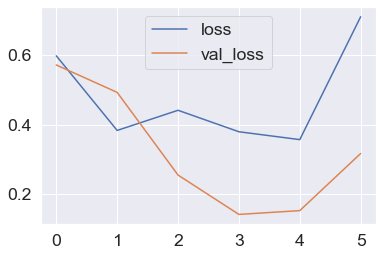

In [26]:
history_df = pd.DataFrame(hist.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

#### Submission

In [ ]:
df_submission.to_csv('submission.csv', index = 0)